In [1]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [2]:
# Loading data
data = load_full_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

# Shuffling data
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Cleaning values in the text column
train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)

In [3]:
combined_data.head()

,text,label
0,oljeeventyr arabisk roman sid oversett geir sk...,2
1,hous hiss greatest hiss new record alternativ ...,2
2,erik bye fått bautabokanmeld asbjørn bakk erik...,2
3,hast kvalitetsvurdering konklusjon kamera klar...,2
4,land skarpest aviskommentator sakpros avis dør...,2


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

# Deciding the vocabulary size
num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 20000


In [5]:
average_text_length = combined_data["text"].str.len().mean()
max_text_length = combined_data["text"].str.len().max()

print("Average text length:", int(average_text_length))
print("Max text length:", int(max_text_length))

Average text length: 1431
Max text length: 12588


In [6]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

# Fitting a tokenizer to text from the combined data
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [8]:
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

Number of classes: 3


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 210)
y_train shape: (34903, 3)

X_val shape: (4360, 210)
y_val shape: (4360, 3)

X_test shape: (4351, 210)
y_test shape: (4351, 3)


In [10]:
import itertools

# 10 most common words in the vocabulary
dict(itertools.islice(tokenizer.word_index.items(), 10))

{'<OOV>': 1,
 'film': 2,
 'gjør': 3,
 'litt': 4,
 'får': 5,
 'komm': 6,
 'spill': 7,
 'først': 8,
 'helt': 9,
 'stor': 10}

In [14]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional

model = Sequential()
model.add(Embedding(num_words, 100, input_length=maxlen))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2, dropout=0.5,
                             recurrent_regularizer=l2(0.005),
                             kernel_regularizer=l2(0.005))))
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,084,867
Trainable params: 2,084,867
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor="val_accuracy", patience=3),
             EarlyStopping(monitor="val_loss", patience=3)]

epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/20
1091/1091 [==============================] - 505s 454ms/step - loss: 0.6520 - accuracy: 0.7605 - val_loss: 0.5306 - val_accuracy: 0.7963
Epoch 2/20
1091/1091 [==============================] - 507s 465ms/step - loss: 0.4804 - accuracy: 0.8033 - val_loss: 0.5123 - val_accuracy: 0.8005
Epoch 3/20
1091/1091 [==============================] - 458s 420ms/step - loss: 0.4114 - accuracy: 0.8356 - val_loss: 0.5699 - val_accuracy: 0.7553
Epoch 4/20
1091/1091 [==============================] - 440s 403ms/step - loss: 0.3555 - accuracy: 0.8622 - val_loss: 0.5891 - val_accuracy: 0.7963
Epoch 5/20
1091/1091 [==============================] - 428s 393ms/step - loss: 0.2990 - accuracy: 0.8904 - val_loss: 0.6206 - val_accuracy: 0.7617


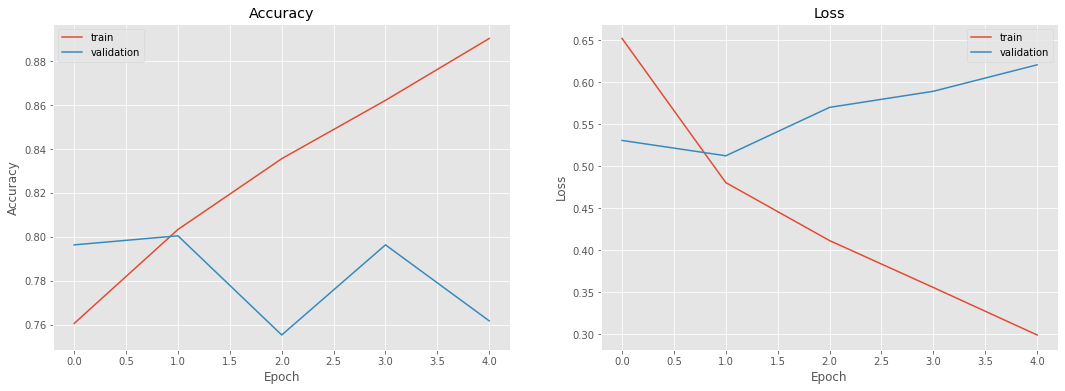

In [17]:
from sena.utils.visualization import plot_history

plot_history(history)

In [18]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 7s 53ms/step - loss: 0.5875 - accuracy: 0.7640
Validation loss: 0.5875062942504883
Validation accuracy: 0.7639623284339905


In [19]:
from datetime import datetime

if val_acc > 0.8:
    print("Saving model...")
    model.save(f"models/SA-LSTM-MULTICLASS-{val_acc}-{datetime.now().strftime('%Y%m%d')}.h5")